In [1]:
#Brian Shula, 2024

# Second Order ODE for spring-mass-damper system

Boyce and DiPrima - Elementary Differential Equations and Boundary Value Problems, 7th Edition,
Section 3.8, Example 3

u'' + 0.125u' + u = 0

Initial Conditions:

u(0) = 2, 
u'(0) = 0

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

import torch
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import CosineAnnealingLR

torch.manual_seed(47)

In [3]:
#Array of time points
t = np.linspace(0, 50, 1000)

In [4]:
def exact_sol(x):
    #Exact Solution
    omega = np.sqrt(255/256)
    return np.exp(-x / 16) * (2 * np.cos(omega * x) + (2 / np.sqrt(255)) * np.sin(omega * x) )

In [5]:
#get solution values
u = exact_sol(t)

# Solve Numerically using SciPy

Solve a system of first-order ODEs using scipy.integrate.solve_ivp:

Let x1 = u and x2 = u'.  Then, x2' = u''.

The original equation can be rewritten in terms of x1 and x2:

x1' = u''

x2' = -0.125 * x2 - x1, 

with x1(0) = 2 and x2(0) = 0.

In [6]:
#Funciton for evalation: returns coefficients matrix multiplied by [x1, x2].T in system
def odesol(x, Y):
    return [Y[1], -Y[0] - 0.125 * Y[1]]
    

In [7]:
#Timespan for numerical integration
tspan = [t.min(), t.max()]

#Initial conditions for x1, x2
u_init = [2. , 0.]

#Perform numerical integration
sol = solve_ivp(odesol, tspan, u_init, method='RK45', t_eval=t)

Text(0.5, 1.0, 'Numerical and Exact Solutions for the Spring-Mass-Damper System')

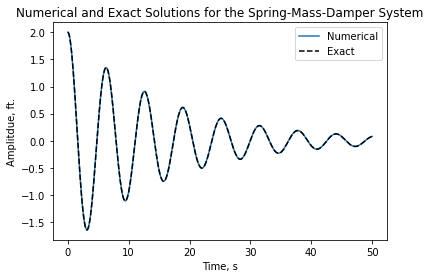

In [8]:
#Plot Numerical and Exact solutions
plt.plot(t, sol.y[0], label='Numerical')
plt.plot(t, u, 'k', ls='--', label='Exact')
plt.legend()
plt.xlabel('Time, s')
plt.ylabel('Amplitdue, ft.')
plt.title('Numerical and Exact Solutions for the Spring-Mass-Damper System')

# PINN Data Preparation 
Solution Data is prepared by defining the time range and number of data points.  The solution data is generated from the numerical solution defined above.  Train and Test sets are split from the data and converted to PyTorch Tensors.  The data points are also plotted. 

In [9]:
#Setup for data and collocation points
tmin = 0
tmax = 50
ndata = 500
ncoll = 1000

In [10]:
#input and solution values
t_data = np.linspace(tmin, tmax, ndata)

u_data = solve_ivp(odesol, [0, tmax], u_init, method='RK45', t_eval=t_data)

In [11]:
#Store inputs-outputs in single array so pairs are kept when shuffled
data = np.column_stack((u_data.t, u_data.y[0]))

#Random shuffle - shuffle data pairs for splitting
np.random.seed(23)

rng = np.random.default_rng()
rng.shuffle(data)

In [12]:
#Training data sets
t_train = data[:int(0.9*ndata), 0]
t_test = data[int(0.9*ndata):, 0]

u_train = data[:int(0.9*ndata), 1]
u_test = data[int(0.9*ndata):, 1]

#Expand dims from (ndata,) to (ndata,1), etc.
t_train = np.expand_dims(t_train, axis=1)
t_test = np.expand_dims(t_test, axis=1)

u_train = np.expand_dims(u_train, axis=1)
u_test = np.expand_dims(u_test, axis=1)

In [13]:
#Convert Inputs, Outputs to Torch tensors
t_train_pt = torch.tensor(t_train, dtype=torch.float32)
t_test_pt = torch.tensor(t_test, dtype=torch.float32)

u_train_pt = torch.tensor(u_train, dtype=torch.float32)
u_test_pt = torch.tensor(u_test, dtype=torch.float32)

Text(0.5, 1.0, 'Train and Test Points')

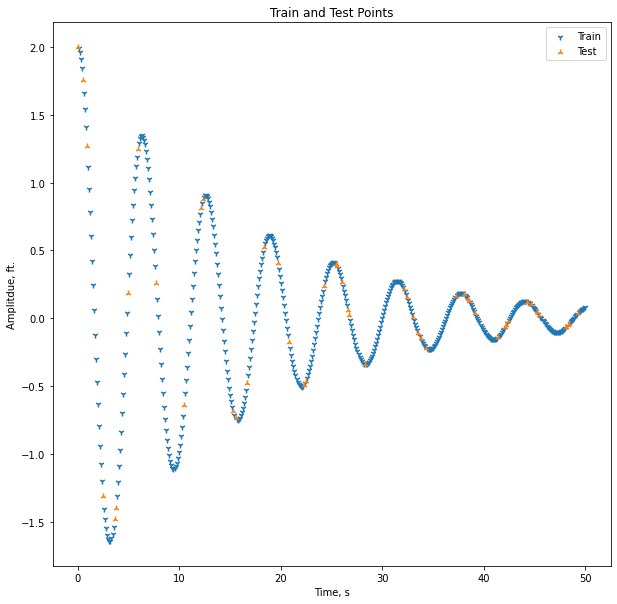

In [14]:
plt.subplots(figsize=(10, 10))
plt.scatter(t_train, u_train, marker='1', label='Train')
plt.scatter(t_test, u_test, marker='2', label='Test')
plt.legend()
plt.xlabel('Time, s')
plt.ylabel('Amplitdue, ft.')
plt.title('Train and Test Points')

# PINN Model Setup

## Physics Loss Function
The Physics Loss Function calculates u' and u'' w.r.t. t for the collocation points. The residual is calculated from the original ODE, where u'' + 0.125*u' + u = 0.

In [15]:
def physics_loss(t, net):
    u_pred = net(t)
    dudt = torch.autograd.grad(u_pred, t, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t, grad_outputs=torch.ones_like(dudt), create_graph=True)[0]
    
    #Calculate residuals
    #u'' + 0.125u' + u = 0
    res = d2udt2 + 0.125*dudt + u_pred
    
    loss = MSE(res, torch.zeros_like(res))
    
    return loss

## Neural Network setup
The PyTorch PINN is set up to be similar to the TensorFlow PINN.

In [16]:
#Create model
#Attempt to use same architecture and training as TensorFlow Notebook

#Number of Neurons in hidden layers
n_neurons=100

class Surrogate(nn.Module): # all the dependencies from torch will be given to this class [parent class] # nn.Module contains all the building block of neural networks:
    def __init__(self,input_dim, output_dim):
        super(Surrogate,self).__init__()  
        #Fully connected layers
        self.fc1=nn.Linear(input_dim,n_neurons)
        self.fc2=nn.Linear(n_neurons,n_neurons)
        self.fc3=nn.Linear(n_neurons,n_neurons)
        self.fc4=nn.Linear(n_neurons,output_dim)

    def forward(self,x):
        #Construct layers
        x=self.fc1(x)
        x=torch.tanh(x)  
        
        x=self.fc2(x)
        x=torch.tanh(x)  
        
        x=self.fc3(x)
        x=torch.tanh(x) 
        
        x=self.fc4(x)
                     
        return x                               


#Create model    
input_dim = t_train.shape[1]
output_dim = u_train.shape[1]

torch.manual_seed(41)
model=Surrogate(input_dim, output_dim)

##  Optimizer and Supporting Components
The ADAM optimizer is used with learning rate decay.  The Cosine Annealing function decreases the learning rate.

In [17]:
#MSE Loss
MSE = nn.MSELoss()

#Optimizer
opt=optim.Adam(params = model.parameters(), lr = 0.001)

scheduler = CosineAnnealingLR(opt, 
                             T_max = 10000, # Maximum number of iterations.
                             eta_min = 1e-5) # Minimum learning rate.

## Initial Condition data setup

In [18]:
#Initial Conditions data preparation
t_bc = np.array([0])
t_bc = np.expand_dims(t_bc, axis=1)
t_bc_pt = Variable(torch.from_numpy(t_bc).float(), requires_grad=True)

u_true_bc = np.array([2.0])
u_true_bc = np.expand_dims(u_true_bc, axis=1)
u_true_bc_pt = Variable(torch.from_numpy(u_true_bc).float(), requires_grad=True)

## Training 
Training Data is split into batches during the training loop. Collocation points are randonmly chosen for each Epoch. The Total Loss for each Epoch is printed to monitor progress.

In [19]:
# training the model:
loss_history=[]

#Manual batch size
batch_size = 64
starts = torch.arange(0, len(u_train_pt), batch_size)

num_of_epochs=10000
for i in range(num_of_epochs):
    
    #New collocation points every Epoch
    t_coll_pt = np.random.random((ncoll,1))*tmax
    t_coll_pt = Variable(torch.from_numpy(t_coll_pt).float(), requires_grad=True)
    
    #Reset tracked loss
    tracked_loss = 0
    
    #loop over batches
    for start in starts:
        t_train_pt_batch = t_train_pt[start:start+batch_size]
        u_train_pt_batch = u_train_pt[start:start+batch_size]

        # zero gradients
        opt.zero_grad() 

        # predict
        u_pred=model(t_train_pt_batch)  

        # calculate Total Loss and save
        data_loss = MSE(u_pred, u_train_pt_batch) 
        PINN_loss = physics_loss(t_coll_pt, model)

        u_net_bc = model(t_bc_pt)
        IC_loss = MSE(u_net_bc, u_true_bc_pt)

        total_loss = PINN_loss + data_loss + IC_loss

        # back prop
        total_loss.backward()  

        # update weights and learning rate
        opt.step()
        
        tracked_loss = tracked_loss + total_loss.detach().numpy()
    
    #Record Loss on last batch
    loss_history.append(tracked_loss)    
    
    #Update Learning Rate
    scheduler.step()
    
    # print the loss in training part:
    if i % 50 == 0:
        learning_rate = opt.param_groups[0]["lr"]
        print(f'Epoch: {i}: Loss={tracked_loss}, Learning Rate:{learning_rate:.5f}')

Epoch: 0: Loss=14.68782114982605, Learning Rate:0.00100
Epoch: 50: Loss=1.9697485566139221, Learning Rate:0.00100
Epoch: 100: Loss=1.6141845732927322, Learning Rate:0.00100
Epoch: 150: Loss=1.3023881018161774, Learning Rate:0.00100
Epoch: 200: Loss=1.1104524806141853, Learning Rate:0.00100
Epoch: 250: Loss=1.0336368083953857, Learning Rate:0.00100
Epoch: 300: Loss=0.9831370115280151, Learning Rate:0.00100
Epoch: 350: Loss=0.8487665206193924, Learning Rate:0.00100
Epoch: 400: Loss=0.6977465525269508, Learning Rate:0.00100
Epoch: 450: Loss=0.6162973009049892, Learning Rate:0.00100
Epoch: 500: Loss=0.5645604804158211, Learning Rate:0.00099
Epoch: 550: Loss=0.5306473821401596, Learning Rate:0.00099
Epoch: 600: Loss=0.5101711936295033, Learning Rate:0.00099
Epoch: 650: Loss=0.4897354729473591, Learning Rate:0.00099
Epoch: 700: Loss=0.45754314959049225, Learning Rate:0.00099
Epoch: 750: Loss=0.4410382770001888, Learning Rate:0.00099
Epoch: 800: Loss=0.34194555319845676, Learning Rate:0.00098

Epoch: 6650: Loss=0.00011426776927692117, Learning Rate:0.00026
Epoch: 6700: Loss=0.0006419296696549281, Learning Rate:0.00025
Epoch: 6750: Loss=0.00011179249486303888, Learning Rate:0.00025
Epoch: 6800: Loss=0.0020511408292804845, Learning Rate:0.00024
Epoch: 6850: Loss=0.000171995032360428, Learning Rate:0.00023
Epoch: 6900: Loss=0.0001447970107619767, Learning Rate:0.00023
Epoch: 6950: Loss=6.364642331391224e-05, Learning Rate:0.00022
Epoch: 7000: Loss=9.054934798768954e-05, Learning Rate:0.00021
Epoch: 7050: Loss=0.00012016510936518898, Learning Rate:0.00021
Epoch: 7100: Loss=8.57397380968905e-05, Learning Rate:0.00020
Epoch: 7150: Loss=0.00041309426887892187, Learning Rate:0.00020
Epoch: 7200: Loss=0.000135906786454143, Learning Rate:0.00019
Epoch: 7250: Loss=0.0001564044796396047, Learning Rate:0.00018
Epoch: 7300: Loss=0.00010240615574730327, Learning Rate:0.00018
Epoch: 7350: Loss=7.547137192887021e-05, Learning Rate:0.00017
Epoch: 7400: Loss=0.00012370378317427821, Learning Ra

# Model Evaluation
The PINN is able to match the numerical solution quite well.

In [20]:
# evaluate model:
model.eval()

with torch.no_grad():
    t_eval = np.linspace(0,50,1000).reshape(-1,1)
    t_eval_pt = torch.tensor(t_eval, dtype=torch.float32)

    u_eval = model(t_eval_pt)
    u_eval = u_eval.detach().numpy()

[]

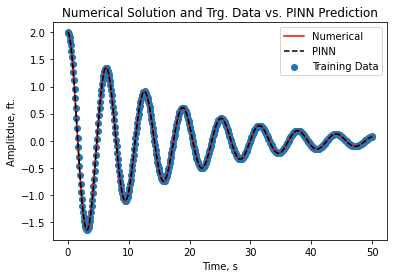

In [21]:
#Plot PINN Performance against Numerical Solution and Training Data
plt.plot(t_eval, sol.y[0], 'r', label='Numerical')
plt.plot(t_eval, u_eval, '--k', label='PINN')
plt.scatter(t_data, u_data.y[0], label='Training Data')
plt.legend()
plt.xlabel('Time, s')
plt.ylabel('Amplitdue, ft.')
plt.title('Numerical Solution and Trg. Data vs. PINN Prediction')
plt.plot()